### Master of Applied Artificial Intelligence

**Course: TC4033 - Computational Vision for Images and Video**

<img src="./../assets/logo.png" alt="Image Alt Text" width="500"/>

**Line Detection with Canny Algorithm**

Tutor: Dr. Gilberto Ochoa


Team members:
* Alfonso de Lucas Espinosa - A01795118
* Ignacio Jose Aguilar Garcia - A00819762
* Alejandro Calderon Aguilar - A01795353
* Ricardo Mar Cupido - A01795394
* Mario Fonseca Martinez - A01795228


### Introduction

### Importing libraries

In [1]:
import cv2
import skimage
import numpy as np
from scipy import ndimage
from skimage import exposure
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.ndimage.filters import convolve
from scipy.ndimage.filters import gaussian_filter as gauss
from scipy.ndimage.filters import median_filter as med

/var/folders/dd/h6ysp6hd74s6ypbck34s5gym0000gn/T/ipykernel_6928/29601034.py:9: DeprecationWarning: Please import `convolve` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import convolve
/var/folders/dd/h6ysp6hd74s6ypbck34s5gym0000gn/T/ipykernel_6928/29601034.py:10: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter as gauss
/var/folders/dd/h6ysp6hd74s6ypbck34s5gym0000gn/T/ipykernel_6928/29601034.py:11: DeprecationWarning: Please import `median_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import median_filter as med


### Loading Images

In [2]:
# Loading images
car = cv2.imread("data/cars.jpg")
car_image = cv2.cvtColor(car, cv2.COLOR_BGR2GRAY)

In [3]:
def plot_images(images=[], labels=[], nrows=1, ncols=2, figsize=(12,8), cmap="gray"):
    """
    Plots a list of images in a grid layout using Matplotlib.

    Parameters:
    images (list): List of images to be plotted.
    labels (list): List of labels for each image. Default is an empty list.
    nrows (int): Number of rows in the grid. Default is 1.
    ncols (int): Number of columns in the grid. Default is 2.
    figsize (tuple): Size of the figure in inches. Default is (12, 8).
    cmap (str): Colormap to be used for displaying the images. Default is "gray".

    Returns:
    None
    """

    # set the subplots
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize)
    # Iterate over each axis defined in M*N as flat
    for i, ax in enumerate(axs.flat):
        # validates that the dimensions of axs fits with images array parameter
        if i < len(images):
            # plot the image
            ax.imshow(images[i], cmap=cmap)
            # if there are labels defined then set a title
            if i < len(labels):
                ax.set_title(labels[i])
            # dont show the axis ticks
            ax.axis("off")
        else:
            # dont show an empty plot
            ax.axis("off")
    # fits the plots
    plt.tight_layout()
    plt.show()


### Canny Edge Detection

Steps:
1. Noise Reduction
2. Gradient Calculation
3. Non-maximum Supression
4. Double Threshold
5. Edge Tracking by Hysteresis

### 1. Noise Reduction
Edge detection are highly sensitive to image noise due to the derivatives behind the algorithm.

We can apply a Gaussian Kernel, the size of the kernel depends on the expected blurring effect. The smaller the less blurring effect.

Equation for Gaussian Kernel of size $(2k+1) \times (2k+1)$

$$
H_{i, j} = \frac{1}{2\pi\sigma^2}exp(-\frac{(i-(k+1))^2 + (j-(k+1))^2}{2\sigma^2}); 1\leq i, j \leq (2k+1)
$$

In [4]:
def gaussian_kernel(size, sigma=1):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g

### 1.1 Sigma Parameter $\sigma$

In [5]:
# Change this parameter
sigma = 10 # 1, 3, 5, 10, 20, ...

### 1.2 Kernel Size Parameter

In [6]:
kernel_size = 3

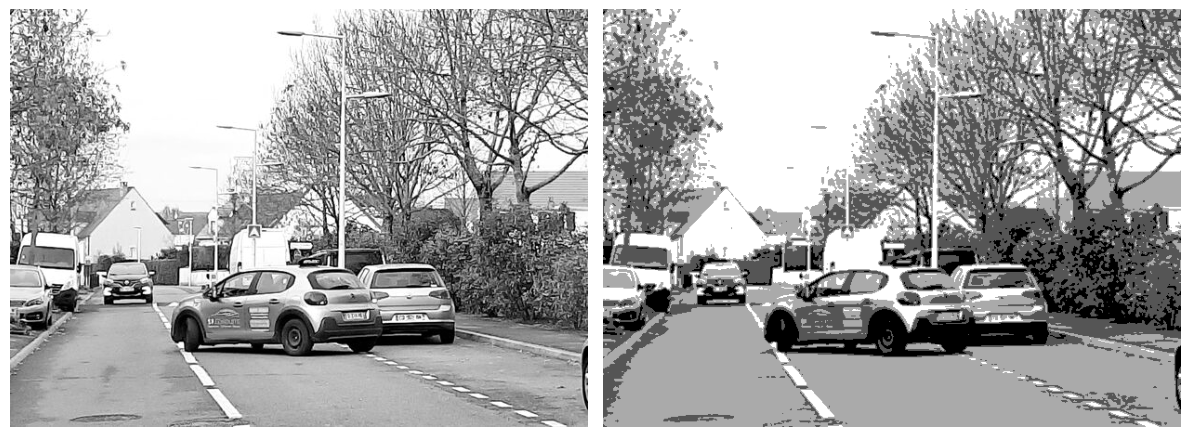

In [7]:
img_gaussian = convolve(car_image.copy(), gaussian_kernel(kernel_size, sigma))
plot_images([car_image, img_gaussian])

### 2. Gradient Calculation

Edges correspond to a change of pixels intensity. 

To detect it, the easiest way is to apply filters that highlight this intensity change in both directions: 
- horizontal $(x)$ 
- and vertical $(y)$

It can be implemented by convoling $I$ with *Sobel kernels* $Kx$ and $Ky$

$$
K_x = \begin{bmatrix}
-1 & 0 & 1\\
-2 & 0 & 2\\
-1 & 0 & 1
\end{bmatrix}, K_y = \begin{bmatrix}
1 & 2& 1\\
0 & 0 & 0\\
-1 & -2 & -1
\end{bmatrix}
$$

Then, the magnitude $G$ and the slope $\theta$ of the gradient are calculated as follow:

$$
|G| = \sqrt{I_x^2 + I_y^2},
\theta(x, y) = arctan(\frac{I_y}{I_x})
$$

In [8]:
def sobel_filters(img):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    
    Ix = ndimage.filters.convolve(img, Kx)
    Iy = ndimage.filters.convolve(img, Ky)
    
    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)
    
    return (G, theta)

/var/folders/dd/h6ysp6hd74s6ypbck34s5gym0000gn/T/ipykernel_6928/65442114.py:5: DeprecationWarning: Please import `convolve` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  Ix = ndimage.filters.convolve(img, Kx)
/var/folders/dd/h6ysp6hd74s6ypbck34s5gym0000gn/T/ipykernel_6928/65442114.py:6: DeprecationWarning: Please import `convolve` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  Iy = ndimage.filters.convolve(img, Ky)


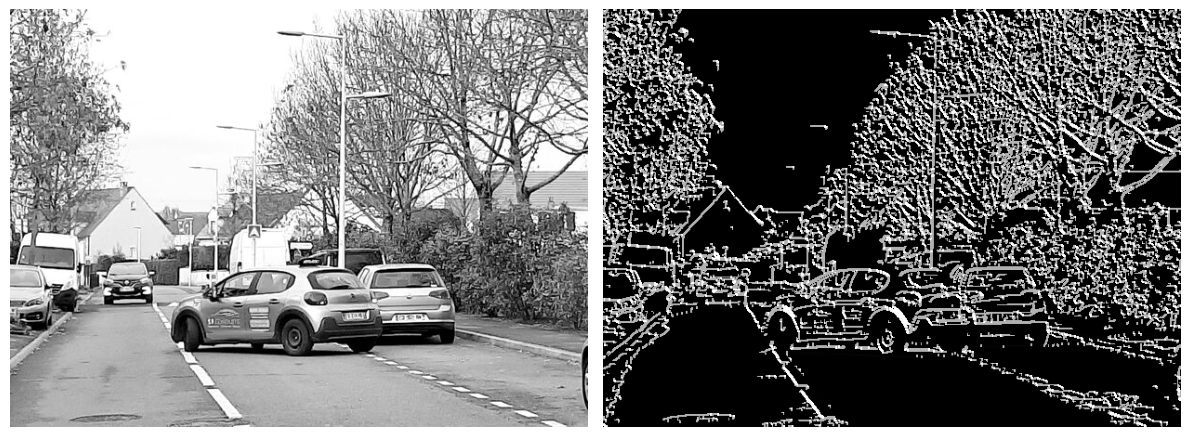

In [9]:
G, theta = sobel_filters(img_gaussian)

plot_images([car_image, G])

### 3. Non-Maximum supression

1. Create a matrix initialized to 0 of the same size of the original gradient intensity matrix
2. Identify the edge direction based on the angle value from the angle matrix
3. Check if the pixel in the same direction has a higher intensity than the pixel that is currently processed
4. Return the image processed with the non-max suppression algorithm.

In [11]:
def non_max_suppression(img, D):
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180

    
    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255
                
               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0

            except IndexError as e:
                pass
    
    return Z

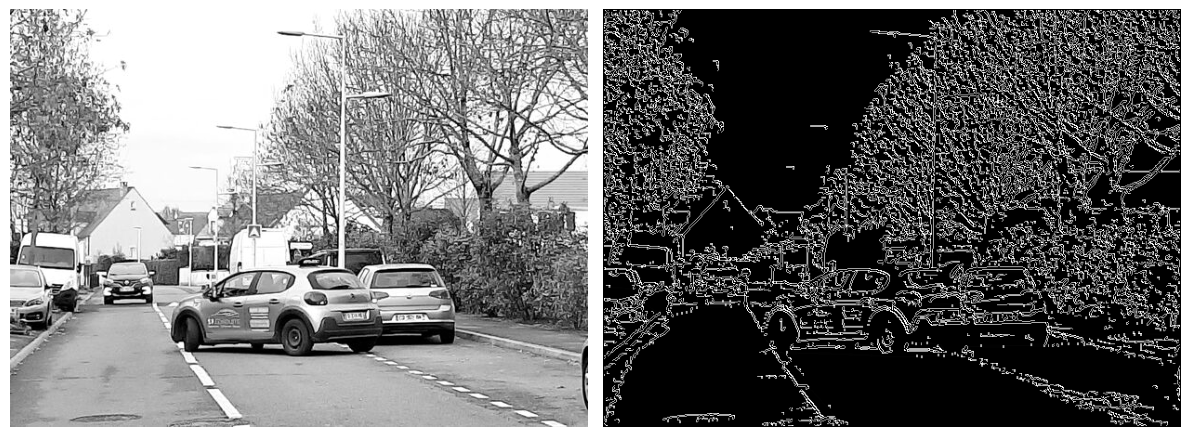

In [12]:
img_nonmax = non_max_suppression(G, theta)

plot_images([car_image, img_nonmax])

### 4. Double threshold

- Strong pixels are pixels that have an intensity so high that we are sure they contribute to the final edge.
- Weak pixels are pixels that have an intensity value that is not enough to be considered as strong ones, but yet not small enough to be considered as non-relevant for the edge detection.
- Other pixels are considered as non-relevant for the edge.

In [13]:
def threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.09):
    
    highThreshold = img.max() * highThresholdRatio;
    lowThreshold = highThreshold * lowThresholdRatio;
    
    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)
    
    weak = np.int32(25)
    strong = np.int32(255)
    
    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)
    
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
    
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    
    return (res)

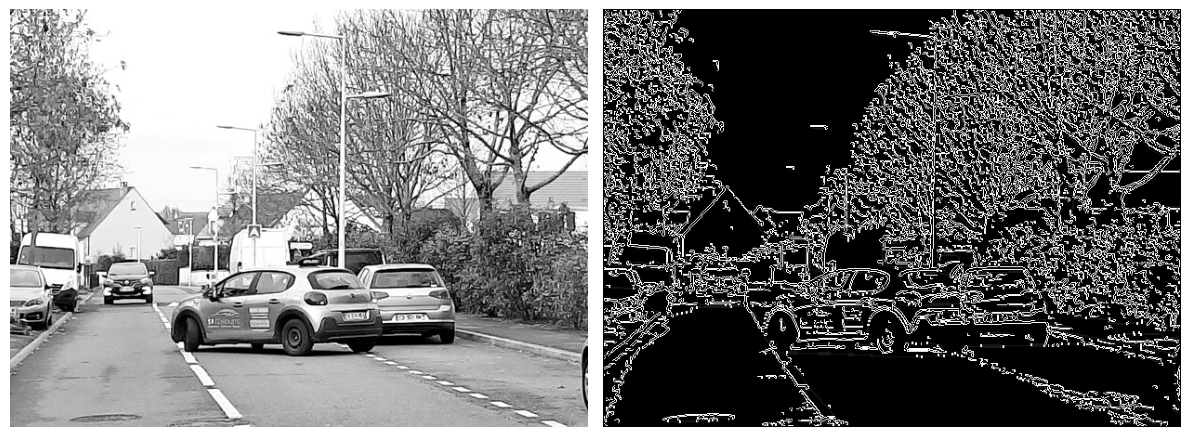

In [14]:
img_threshold = threshold(img_nonmax)

plot_images([car_image, img_threshold])

### 5. Edge Tracking by Hysteresis

The hysteresis consists of transforming weak pixels into strong ones, if and only if at least one of the pixels around the one being processed is a strong one

In [15]:
def hysteresis(img, weak = 75, strong=255):
    M, N = img.shape  
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == weak):
                try:
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong
                    else:
                        img[i, j] = 0
                except IndexError as e:
                    pass
    return img

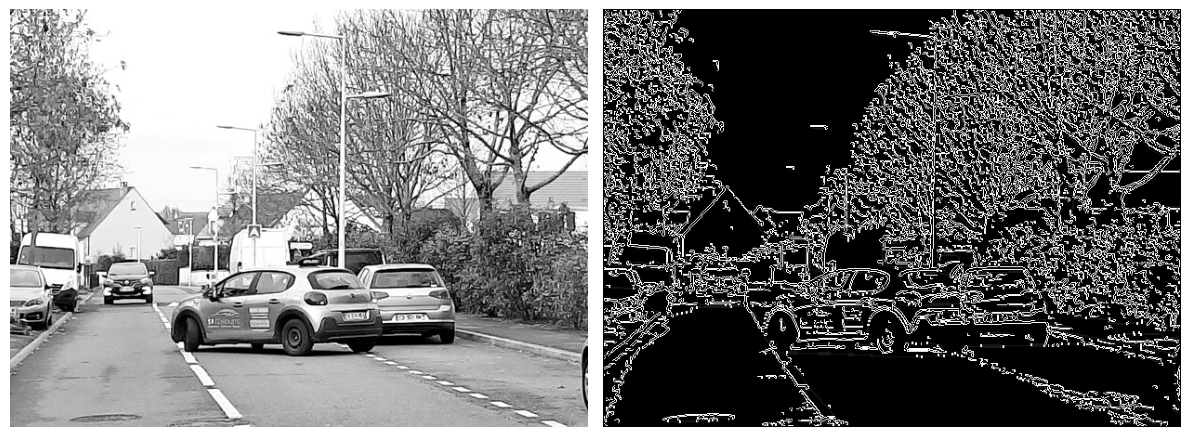

In [16]:
img_final = hysteresis(img_threshold)
plot_images([car_image, img_final])

### Conclusion

### References
